#### Problem -A retail store that has multiple outlets across the country are facing issues in managing the inventory - to match the demand with respect to supply.

You are provided with the weekly sales data for their various outlets
Use statistical analysis, EDA, outlier analysis, and handle the missing values to come up with various
insights


#### Import Necessary libraries

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

#### Load DataSet

In [4]:
data = pd.read_csv("Walmart DataSet.csv")
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [6]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [7]:
data.duplicated().sum()

0

In [8]:
data['Store'].nunique()

45

In [9]:
data['Date'].nunique()

143

In [10]:
data.shape # 45*143=6435

(6435, 8)

### Inferences 
* Number of store - 45
* Sales data available for 143 weeks for each store


In [11]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [12]:
data.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


### Exploratory Data Analysis (EDA)

### Plot the distribution of weekly sales

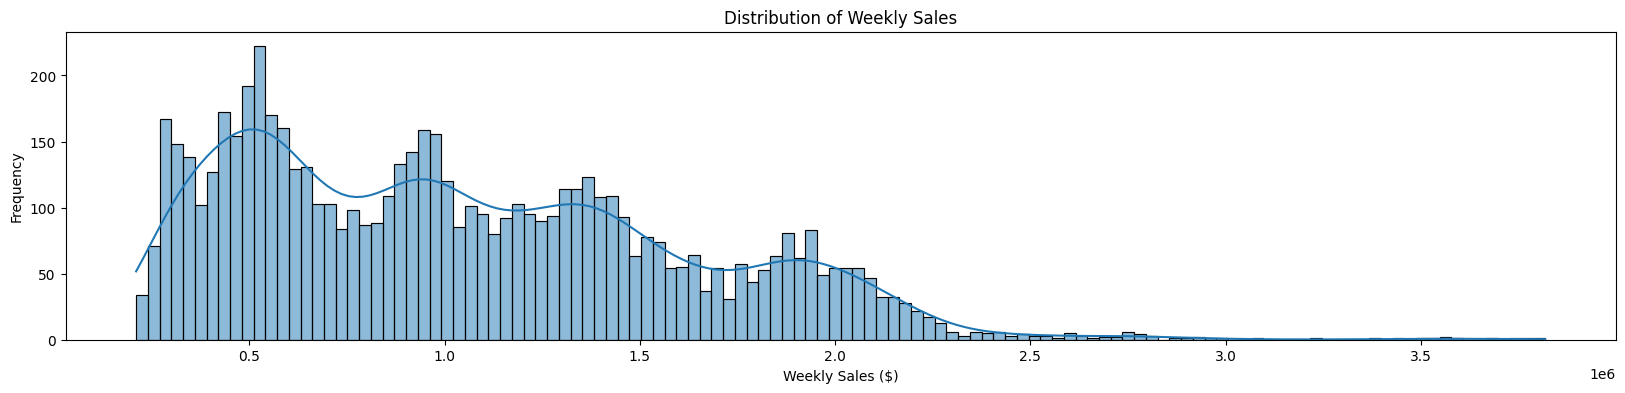

In [13]:
# sns.set(style="whitegrid")
plt.figure(figsize=(20, 4))
sns.histplot(data['Weekly_Sales'], bins=120, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales ($)')
plt.ylabel('Frequency')
plt.show()

### Inferences from the plot
* Central Tendency: The peak of the histogram is around the 0.5 million mark. This suggests that The average weekly sales are around 0.5 million.
* Spread: The spread of the distribution shows a wide range of sales values from around 0.1 million to over 3.5 million. This indicates a high level of variability in weekly sales across different stores and weeks. The variability suggests that some stores/weeks perform significantly better or worse than others
* Skewness: The sales distribution is right-skewed, meaning that there are weeks with exceptionally high sales, but these are less common.
* Kurtosis: This higher peak indicates that the majority of the sales data points are close to the mean, with fewer extreme values than expected in a normal distribution.
* Outliers: There are outliers with very high sales, likely due to specific events or conditions.

### Plot the time series of weekly sales for few stores

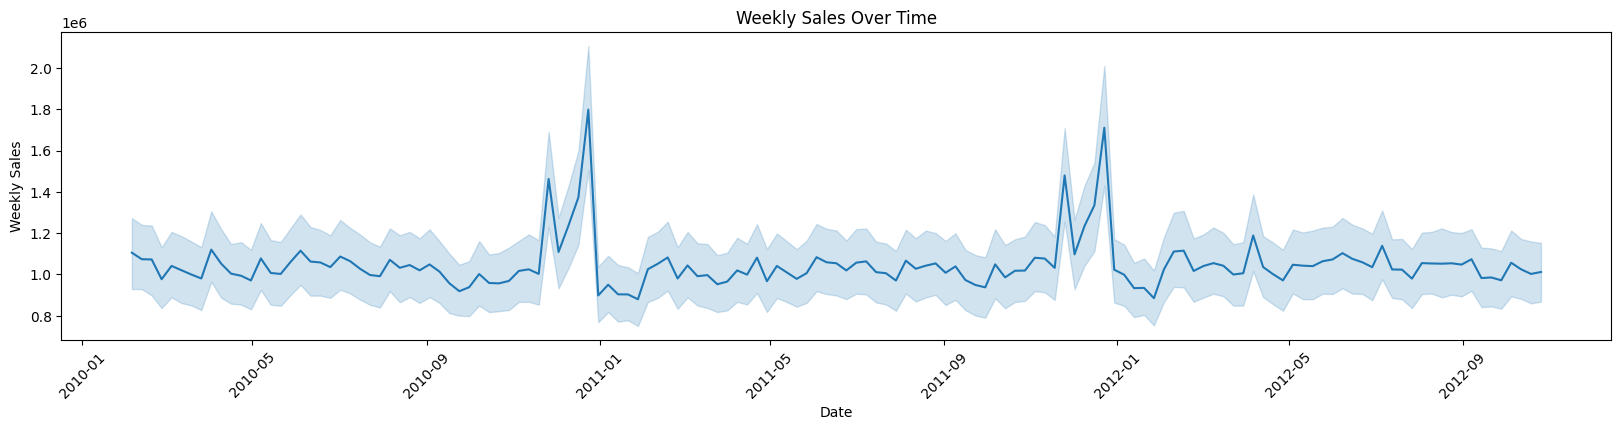

In [14]:
# Plot weekly sales over time
plt.figure(figsize=(20, 4))
sns.lineplot(x=data['Date'], y='Weekly_Sales', data=data)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45) 
plt.show()

In [15]:
def plot_weekly_sales_over_time(stores: list):
    for store in stores:
        store_data = data[data['Store']==store]
        plt.plot(store_data['Date'], store_data['Weekly_Sales'], label=f'Store {store}', alpha=0.5)

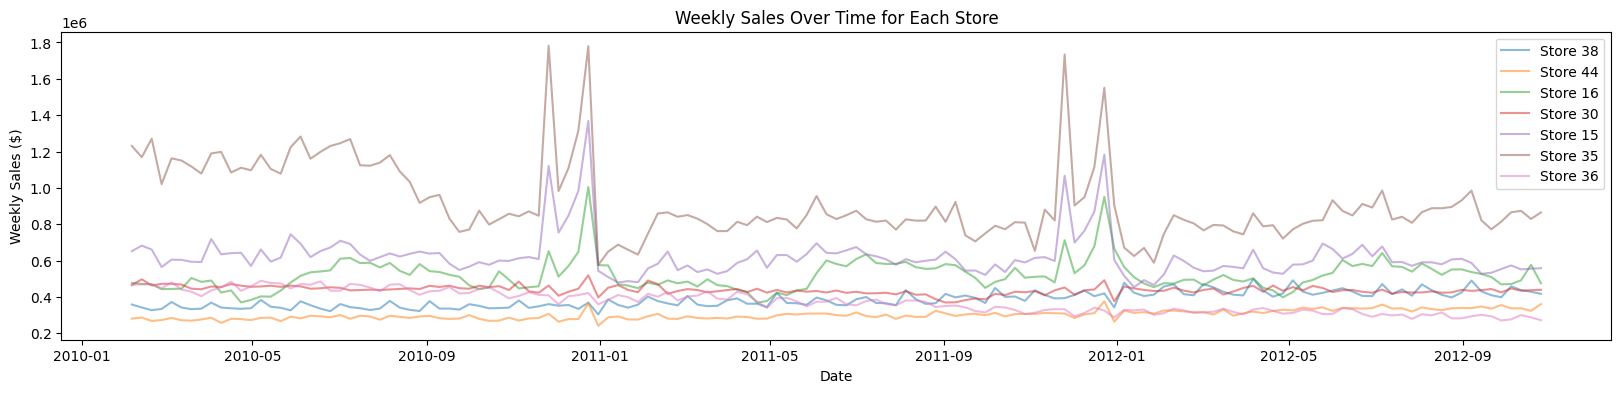

In [16]:
stores = [38, 44, 16, 30, 15, 35, 36]
plt.figure(figsize=(20, 4))
plot_weekly_sales_over_time(stores)

plt.title('Weekly Sales Over Time for Each Store')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.show()

### Inferences from the plot
* Trend Analysis: The plot shows a generally stable trend in weekly sales with no significant upward or downward long-term movement. There are minor fluctuations, but no clear directional trend over the years 2010-2012.
* Seasonality: There are prominent spikes in sales around the same time each year, notably towards the end of the year (November-December). This suggests strong seasonal effects, likely due to the holiday shopping season. These spikes appear consistently each year, indicating a predictable seasonal pattern.
* Anomalies and Outliers: The most noticeable anomalies are the sharp spikes in sales around the end of each year. These are not outliers in a negative sense but rather expected peaks due to seasonal demand. There don't appear to be unexpected outliers outside of these seasonal spikes. The variations within the non-peak periods seem to be within a normal range.
* Business Insights: The end-of-year spikes indicate the holiday season as a period of high demand. The business can prepare for this with increased inventory, staffing, and targeted marketing efforts.Outside of the holiday season, sales appear relatively consistent. This can help in maintaining a steady inventory and regular operations.
* Modeling Decisions: Given the clear seasonality, models like SARIMAX that can handle seasonal effects should be considered over simpler models like ARIMA. Including holiday indicators as exogenous variables in the model can help improve forecasting accuracy during peak seasons.

# b. If the weekly sales show a seasonal trend, when and what could be the reason?


#### From the above plots, it is clear the seasonality is present in the dataset, notably towards the end of the year. Reason could be the holiday shopping, end of season sales, special promotions etc.


### Outlier Analysis


In [17]:
# Detect outliers using the IQR method
Q1 = data['Weekly_Sales'].quantile(0.25)
Q3 = data['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1
outliers = data[(data['Weekly_Sales'] < (Q1 - 1.5 * IQR)) | (data['Weekly_Sales'] > (Q3 + 1.5 * IQR))]

outliers.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
189,2,2010-12-24,3436007.68,0,49.97,2.886,211.064660,8.163
241,2,2011-12-23,3224369.80,0,46.66,3.112,218.999550,7.441
471,4,2010-11-26,2789469.45,1,48.08,2.752,126.669267,7.127
474,4,2010-12-17,2740057.14,0,46.57,2.884,126.879484,7.127
475,4,2010-12-24,3526713.39,0,43.21,2.887,126.983581,7.127


In [18]:
print(f'Number of outliers in Weekly Sales: {len(outliers)}')

Number of outliers in Weekly Sales: 34


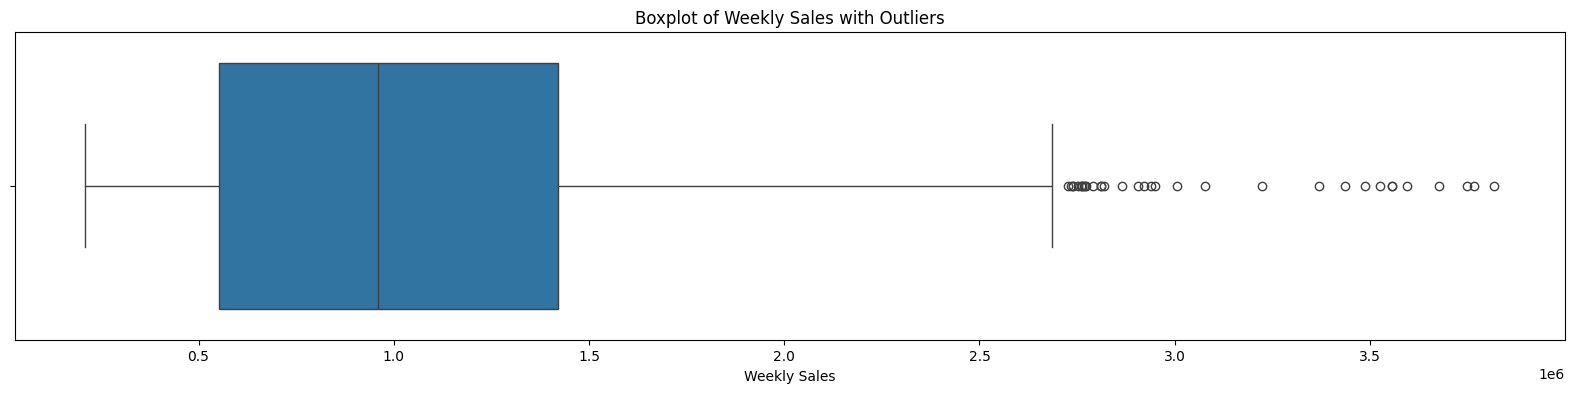

In [19]:
# Plot outliers
plt.figure(figsize=(20, 4))
sns.boxplot(x='Weekly_Sales', data=data)
plt.title('Boxplot of Weekly Sales with Outliers')
plt.xlabel('Weekly Sales')
plt.show()

### Weekly sales by store

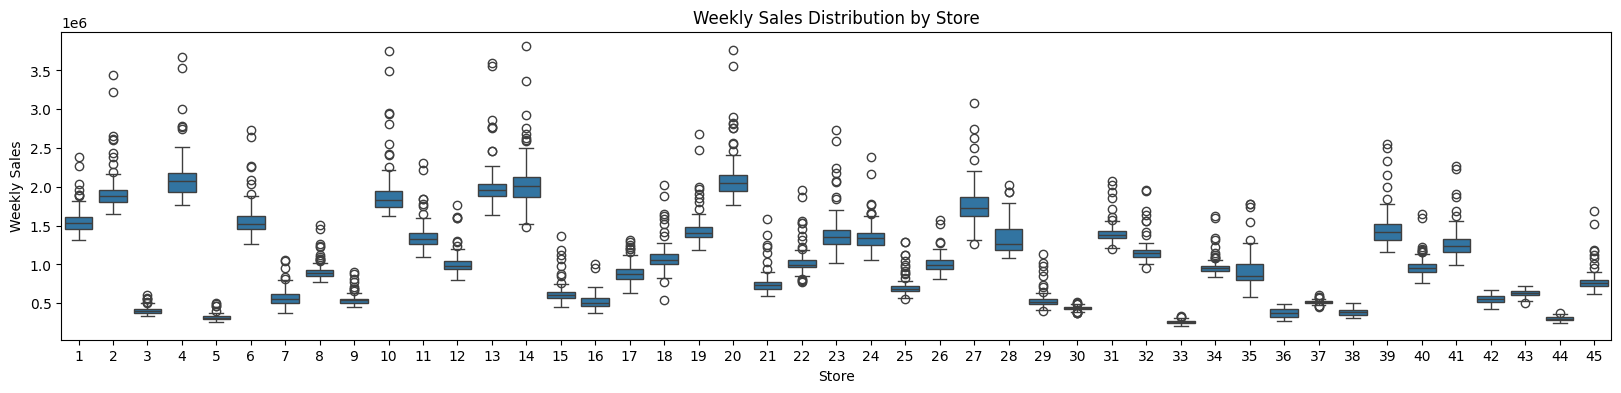

In [20]:
# Boxplot of weekly sales by store
plt.figure(figsize=(20, 4))
sns.boxplot(x='Store', y='Weekly_Sales', data=data)
plt.title('Weekly Sales Distribution by Store')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.show()

### No need to remove outliers, removing those can affect as significant data loss
* Legitimate Data: The outliers represent actual, unusual but real events (e.g., holiday sales spikes, special promotions), they contain valuable information and should be retained. 
* Business Context: Outliers represent critical business insights, such as peak periods, and removing them could lead to a loss of important information.


### Analyze the Impact of External Factors
* To analyze the impact of Holiday_Flag, Unemployment, Temperature, CPI and Fuel_Price on weekly sales, we can use scatter plots and correlation analysis

In [21]:
# Scatter plots
def impact_analysis_scatter_plot(df):
    sns.pairplot(df, x_vars=['Holiday_Flag', 'Unemployment', 'Temperature', 'CPI', 'Fuel_Price'], y_vars='Weekly_Sales', height=5, aspect=0.7)
    plt.show()

In [22]:
# Correlation analysis
def impact_analysis_heatmap(df):
    correlations = df[['Weekly_Sales', 'Holiday_Flag', 'Unemployment', 'Temperature', 'CPI', 'Fuel_Price']].corr()
    plt.figure(figsize=(20, 4))
    sns.heatmap(correlations, annot=True, cmap='coolwarm')
    plt.show()

#### For all stores

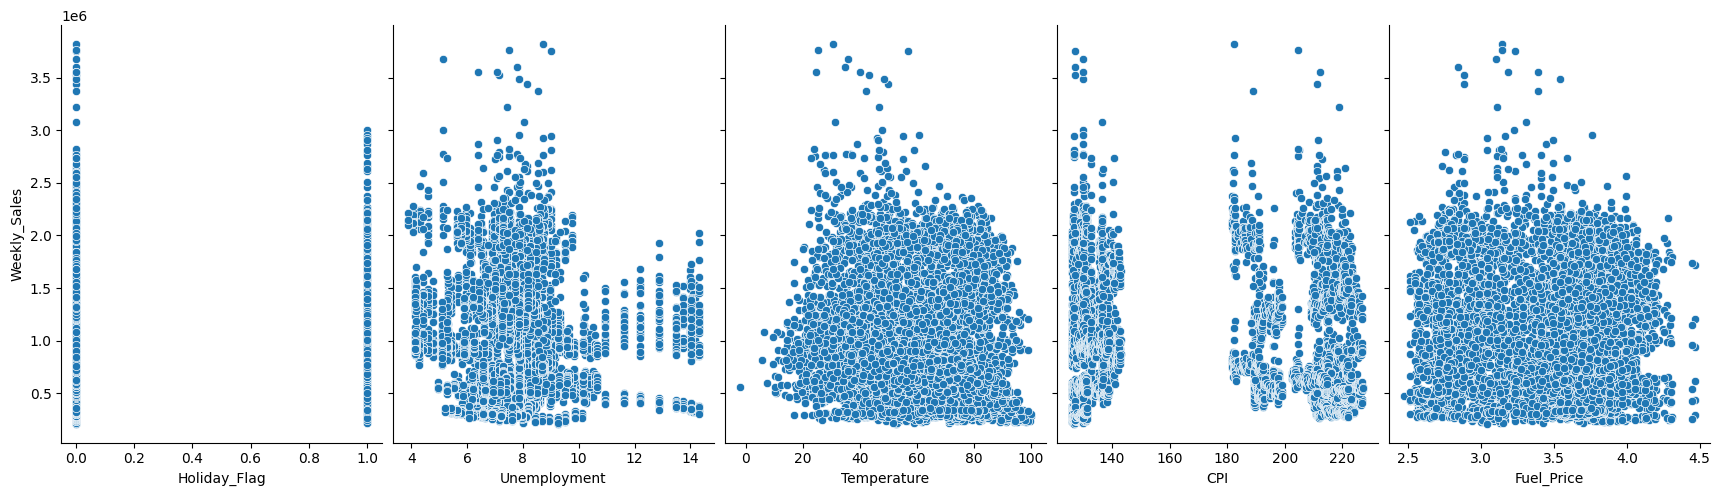

In [23]:
impact_analysis_scatter_plot(data)

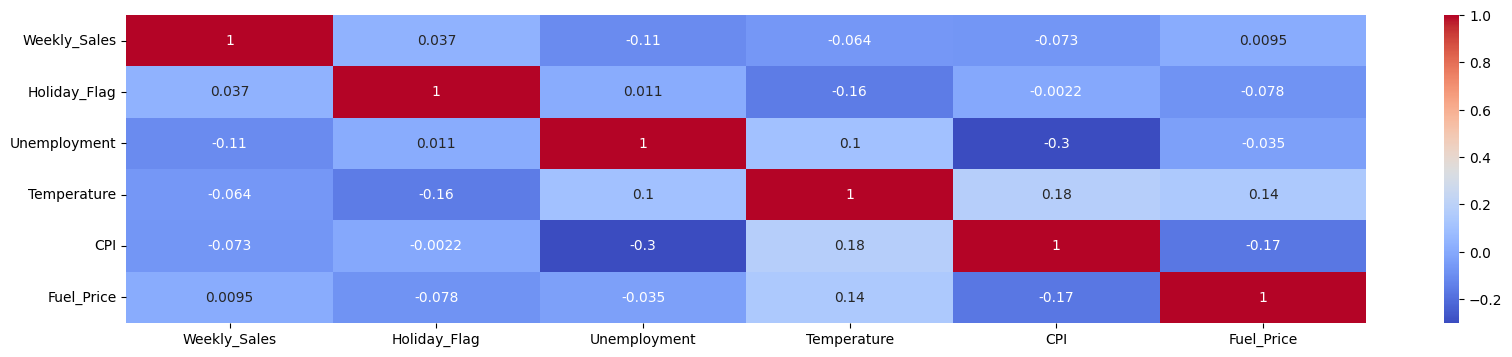

In [24]:
impact_analysis_heatmap(data)

#### For few stores

In [25]:
store_data_36 = data[data['Store']==36]

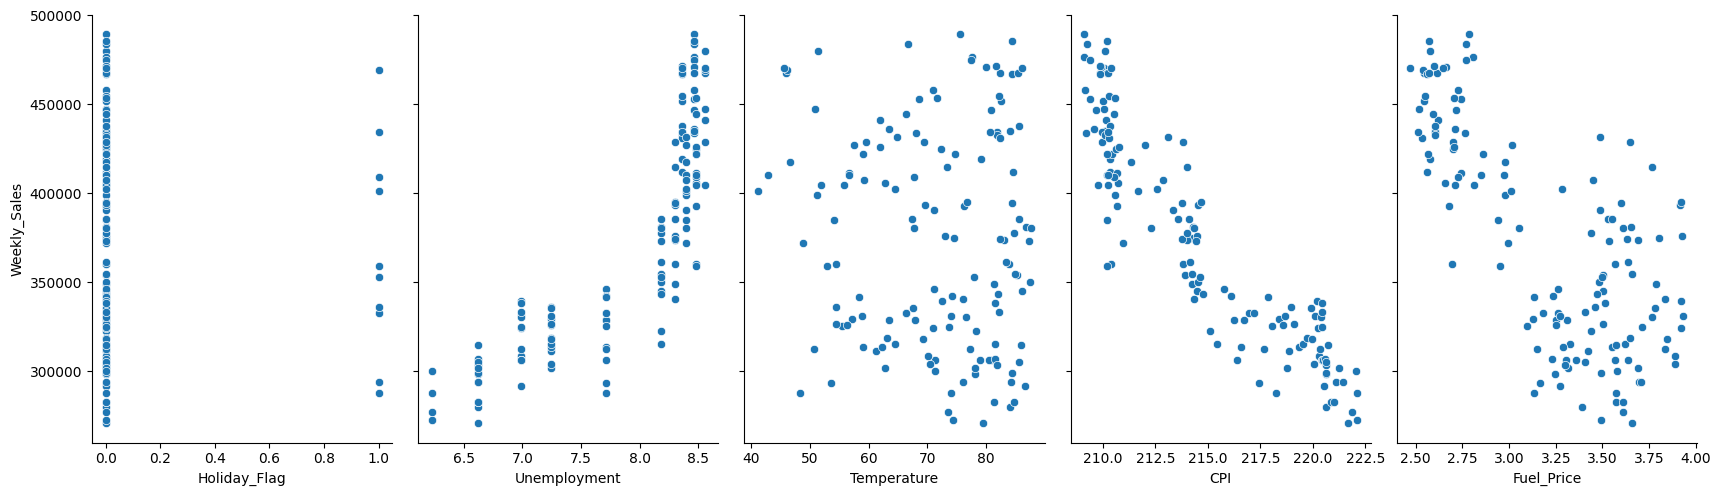

In [26]:
impact_analysis_scatter_plot(store_data_36)

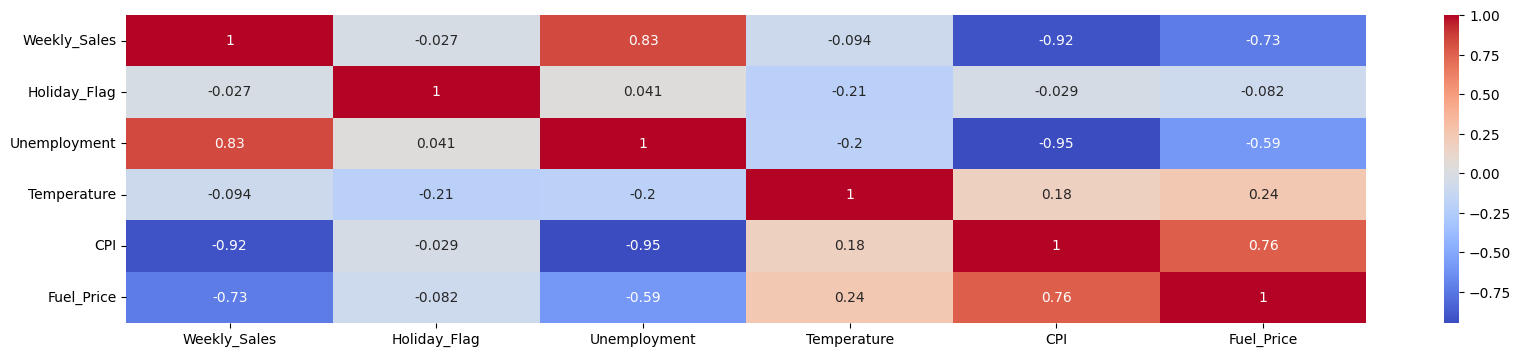

In [27]:
impact_analysis_heatmap(store_data_36)

### Inferences
* There is some affect of Unemployment on Weekly_Sales, but it varies store wise. Lets find out the stores which are suffering the most.

# a. If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?

In [28]:
stores = data['Store'].unique()
unemployment_correlation_results = []

In [29]:
# Loop through each store
for store in stores:
    store_data = data[data['Store'] == store]
    corr, _ = pearsonr(store_data['Weekly_Sales'], store_data['Unemployment'])
    unemployment_correlation_results.append((store, corr))

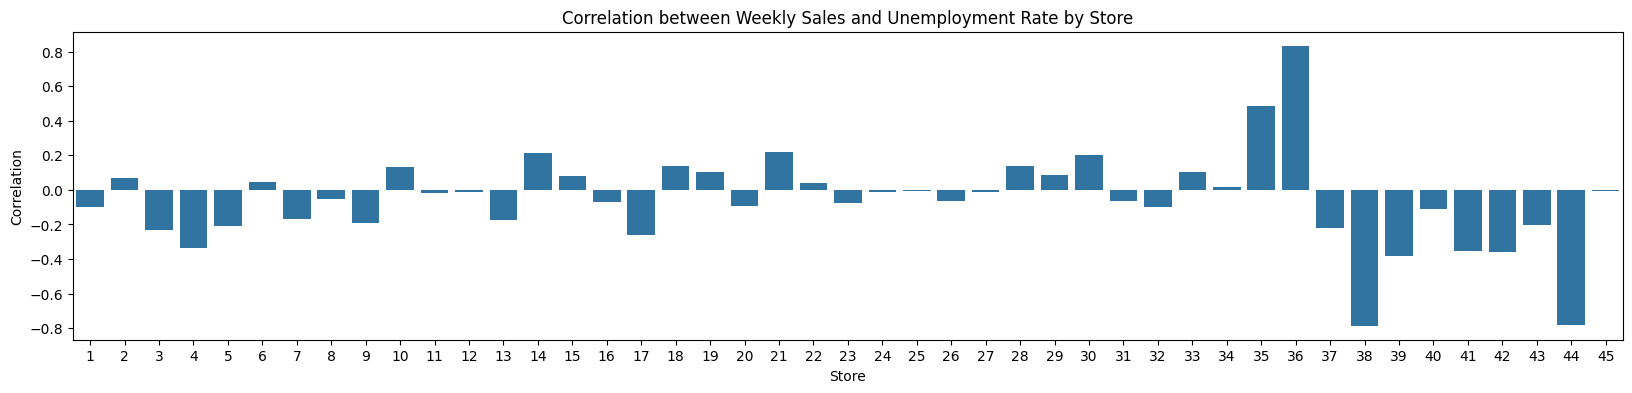

In [30]:
# Create a DataFrame with the correlation results
unemp_correlation_df = pd.DataFrame(unemployment_correlation_results, columns=['Store', 'Correlation'])

# Plot the correlation results
plt.figure(figsize=(20, 4))
sns.barplot(x='Store', y='Correlation', data=unemp_correlation_df)
plt.title('Correlation between Weekly Sales and Unemployment Rate by Store')
plt.xlabel('Store')
plt.ylabel('Correlation')
plt.show()

In [31]:
threshold = .7
for i in range(len(unemployment_correlation_results)):
    if abs(unemployment_correlation_results[i][1]) >= threshold:
        print(f'Most Affected Store - {unemployment_correlation_results[i][0]}')


Most Affected Store - 36
Most Affected Store - 38
Most Affected Store - 44


### Inferences
* The Mostly affected stores are - store no.- 36, 38, 44

# c. Does temperature affect the weekly sales in any manner?

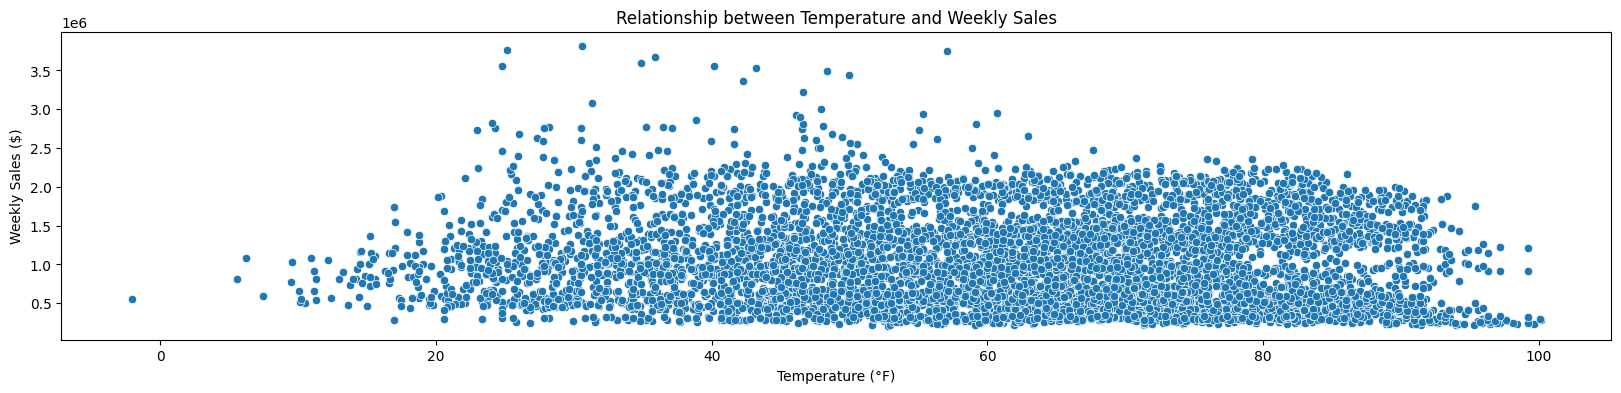

In [32]:
# Function to plot the relationship between temperature and weekly sales
def plot_temperature_sales_relationship(data):
    plt.figure(figsize=(20, 4))
    sns.scatterplot(x='Temperature', y='Weekly_Sales', data=data)
    plt.title('Relationship between Temperature and Weekly Sales')
    plt.xlabel('Temperature (°F)')
    plt.ylabel('Weekly Sales ($)')
    plt.show()

# Plot the relationship for the entire dataset
plot_temperature_sales_relationship(data)

### Inferences
* Do not show clear, strong relationships with Weekly_Sales in the scatter plots, no trend is there

#### Check for few stores 

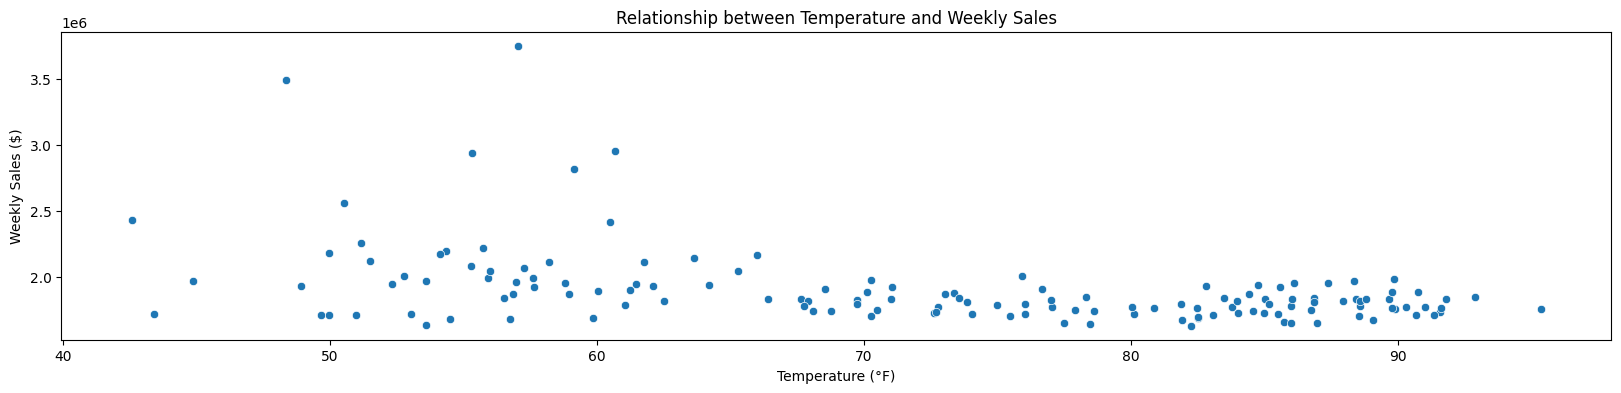

In [33]:
store_data = data[data['Store'] == 10]
plot_temperature_sales_relationship(store_data)

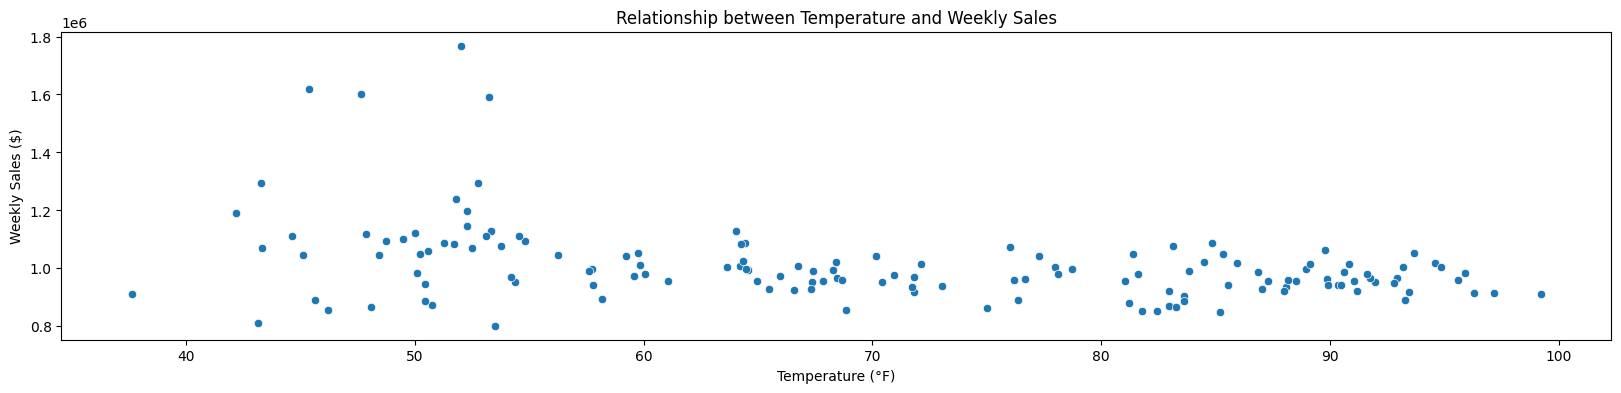

In [34]:
store_data = data[data['Store'] == 12]
plot_temperature_sales_relationship(store_data)

### Inferences - Temperature vs. Weekly_Sales:
* There is no clear trend visible between Temperature and Weekly_Sales. Sales are widely spread across all temperature ranges, suggesting that temperature alone may not be a strong predictor of weekly sales.

# d. How is the Consumer Price index affecting the weekly sales of various stores?

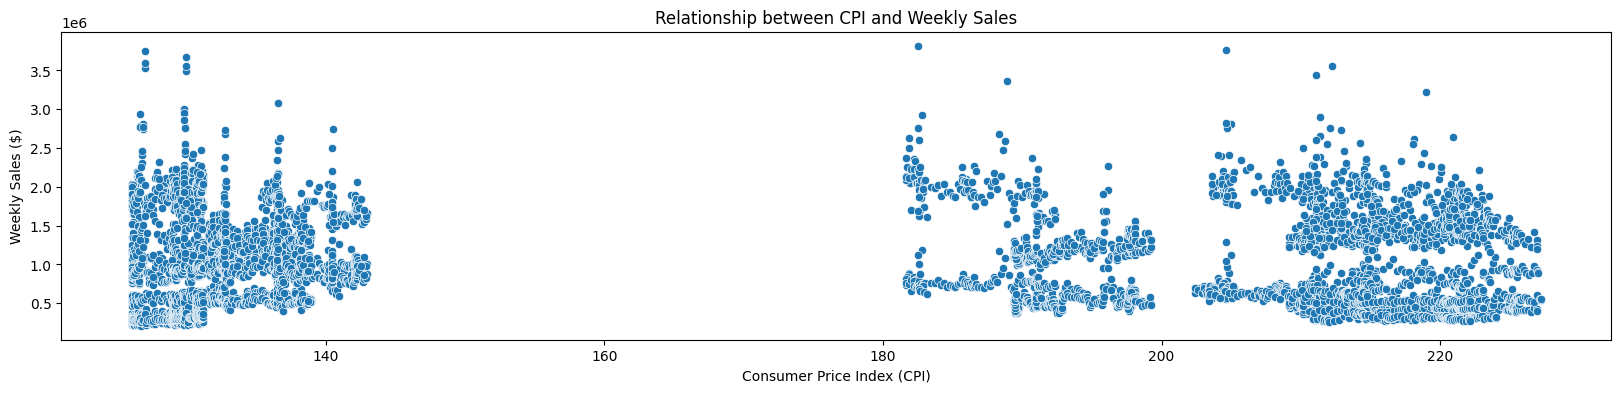

In [35]:
# Function to plot the relationship between CPI and weekly sales
def plot_cpi_sales_relationship(data):
    plt.figure(figsize=(20, 4))
    sns.scatterplot(x='CPI', y='Weekly_Sales', data=data)
    plt.title('Relationship between CPI and Weekly Sales')
    plt.xlabel('Consumer Price Index (CPI)')
    plt.ylabel('Weekly Sales ($)')
    plt.show()

# Plot the relationship for the entire dataset
plot_cpi_sales_relationship(data)

### Inference
* There is no obvious upward or downward trend in the data points, suggesting that changes in CPI do not have a clear linear effect on weekly sales.
* The data points are widely scattered, indicating a weak or non-linear relationship between CPI and weekly sales.


#### Plot for few stores

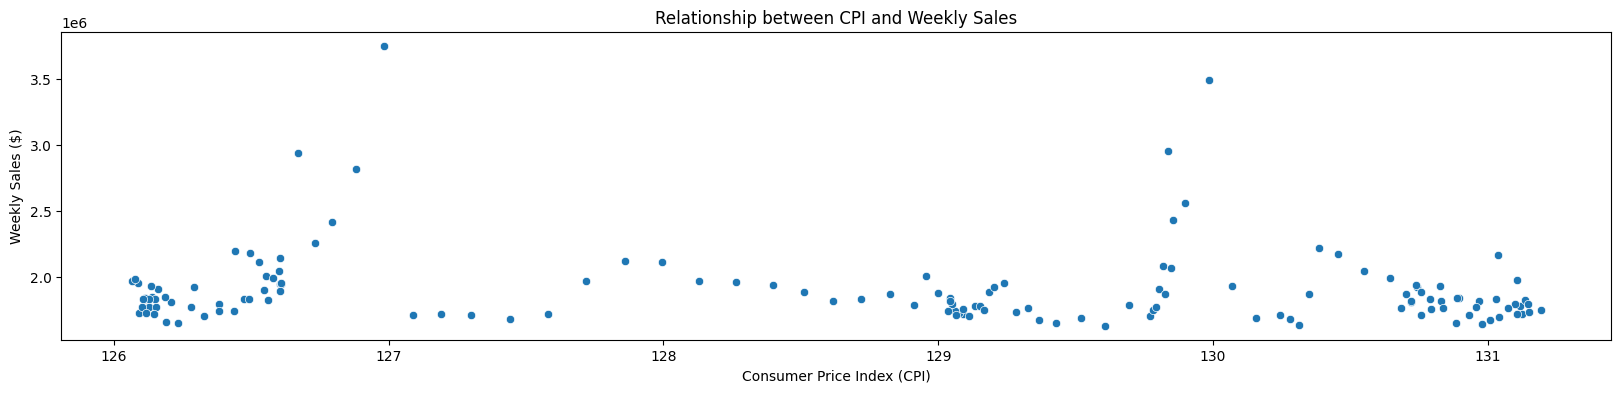

In [36]:
store_data = data[data['Store'] == 10]
plot_cpi_sales_relationship(store_data)

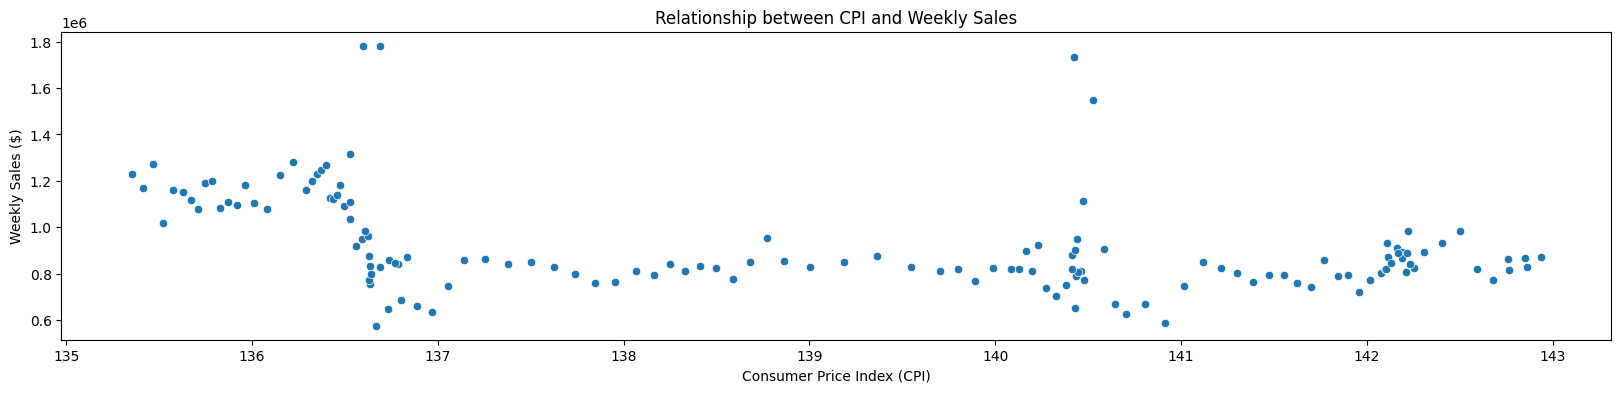

In [37]:
store_data = data[data['Store'] == 35]
plot_cpi_sales_relationship(store_data)

### Inferences - CPI vs. Weekly_Sales:
* CPI (Consumer Price Index) plot shows a wide spread of Weekly_Sales across different CPI values. There is no obvious pattern indicating a direct relationship between CPI and weekly sales.

# e. Top performing stores according to the historical data

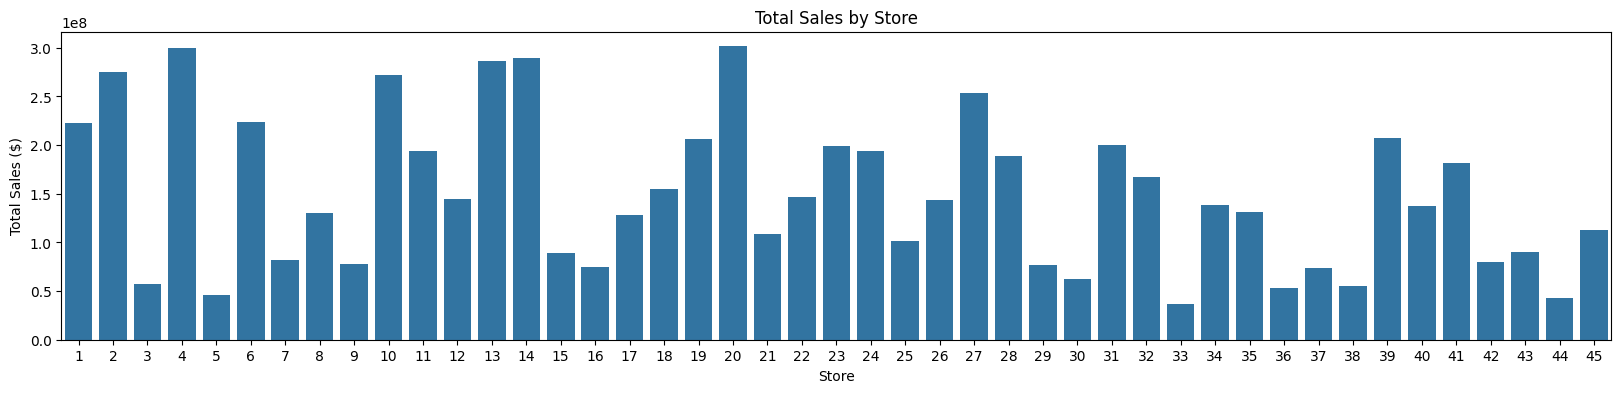

In [38]:
# Step 1: Aggregate Sales Data
total_sales_per_store = data.groupby('Store')['Weekly_Sales'].sum().reset_index()

# Step 2: Rank Stores by Total Sales
total_sales_per_store = total_sales_per_store.sort_values(by='Weekly_Sales', ascending=False)

# Step 3: Visualize the Results
plt.figure(figsize=(20, 4))
sns.barplot(x='Store', y='Weekly_Sales', data=total_sales_per_store)
plt.title('Total Sales by Store')
plt.xlabel('Store')
plt.ylabel('Total Sales ($)')
plt.show()

#### Display the top-performing stores

In [39]:
# Display the top-performing stores
top_performing_stores = total_sales_per_store.head(5)
print("Top performing stores according to the historical data:")
print(top_performing_stores)

Top performing stores according to the historical data:
    Store  Weekly_Sales
19     20  3.013978e+08
3       4  2.995440e+08
13     14  2.889999e+08
12     13  2.865177e+08
1       2  2.753824e+08


# f. The worst performing store, and how significant is the difference between the highest and lowest performing stores.


In [40]:
# Identify the worst performing store
worst_performing_store = total_sales_per_store.iloc[-1]

# Identify the best performing store
best_performing_store = total_sales_per_store.iloc[0]

# Step 3: Calculate the Difference
sales_difference = best_performing_store['Weekly_Sales'] - worst_performing_store['Weekly_Sales']
print(f'The total sales difference between the highest and lowest performing stores- {sales_difference}')

The total sales difference between the highest and lowest performing stores- 264237570.49999997


# 2. Use predictive modeling techniques to forecast the sales for each store for the next 12 weeks.

In [41]:
# Plot time series data
def plot_sales_over_time(store_data):
    plt.figure(figsize=(20, 4))
    sns.lineplot(x=store_data.index, y='Weekly_Sales', data=store_data)
    plt.title('Weekly Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.xticks(rotation=45) 
    plt.show()

In [42]:
# Use auto_arima to determine the best order
def auto_arima_order_check(store):
    store_data =  data[data['Store'] == store]
    arima_model = auto_arima(store_data['Weekly_Sales'], exogenous=store_data[['Unemployment', 'Holiday_Flag']],
                         seasonal=True, m=52, trace=True, error_action='ignore', suppress_warnings=True)
    return arima_model.order, arima_model.seasonal_order

### Prepare the exogenous variables for the forecast period

In [43]:
# Create a DataFrame for future dates
store_data = data[data['Store'] == 1].set_index('Date').asfreq('W-FRI')
future_dates = pd.date_range(start=store_data.index[-1], periods=13, freq='W-FRI').tolist()[1:]

In [44]:
# Prepare the exogenous variables for the forecast period
def future_exogenous_data(store_data):
    future_exog = pd.DataFrame({
        'Unemployment': [store_data['Unemployment'].iloc[-1]] * 12, # Assuming unemployment will remain constant
        'Holiday_Flag': [0,0,0,0,0,0,0,0,1,0,0,0]
    }, index=future_dates)

    return future_exog

### Reasons to select SARIMAX
* SARIMAX can handle both seasonality and exogenous variables like Unemployment, Holiday_Flag, etc.
* ARIMA is not suitable for datasets with seasonality and external regressors like this one.

In [45]:
# Function to fit SARIMA model and forecast
def sarima_forecast(store_data, order, seasonal_order, steps):
    model = SARIMAX(store_data['Weekly_Sales'], order=order, seasonal_order=seasonal_order, exog=store_data[['Unemployment', 'Holiday_Flag']])
    # model = SARIMAX(store_data['Weekly_Sales'], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps=steps, exog=future_exogenous_data(store_data))
    # forecast = model_fit.get_forecast(steps=steps)
    return forecast.predicted_mean, model_fit

In [46]:
# Plot Forecast
def plot_forecast(store_data, forecast, store):
    plt.figure(figsize=(20, 4))
    plt.plot(store_data['Weekly_Sales'], label='Historical Sales')
    plt.plot(forecast.index, forecast, label='Forecast', color='red')
    plt.title(f'Store {store} Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.show()

### Forecast for Store

In [47]:
# Forecast for Store
def forecast_result_for_store(store, order=(3, 0, 2), seasonal_order = (1, 0, 0, 52)):
    store_data = data[data['Store'] == store].set_index('Date').asfreq('W-FRI')
    
    # Check for stationarity and difference if necessary
    diff_flag = False
    result = adfuller(store_data['Weekly_Sales'])
    if result[1] > 0.05:  # If the series is not stationary, difference it
        store_data['Weekly_Sales'] = store_data['Weekly_Sales'].diff()
        diff_flag = True
    store_data.dropna(inplace=True)
    
    # Fit SARIMA model
    forecast, model_fit = sarima_forecast(store_data, order, seasonal_order, steps=12)
    
    # plot_forecast(store_data, forecast, store)
    
    return forecast, diff_flag

### Forecast into Original Scale

In [48]:
# Froecast in original scale
def forecast_sales_in_original_scale(forecast, store):
    forecast_diff = pd.Series(forecast.values, index=forecast.index)

    # To reverse the differencing
    last_observed_value = data[data['Store']==store]['Weekly_Sales'].iloc[-1]
    forecast_original_scale = np.empty(len(forecast_diff))
    forecast_original_scale[0] = last_observed_value + forecast_diff.iloc[0]

    for i in range(1, len(forecast_diff)):
        forecast_original_scale[i] = forecast_original_scale[i - 1] + forecast_diff.iloc[i]

    # Convert the result to a DataFrame for better visualization
    forecast_original_scale = pd.DataFrame(forecast_original_scale, index=forecast_diff.index, columns=['Forecast'])
    forecast_original_scale['Store'] = store

    return forecast_original_scale

In [49]:
# Plot the forecast in original scale
def plot_forecast_into_original_scale(store, forecast_original):
    original_sales = data[data['Store']==store].set_index('Date')
    plt.figure(figsize=(24, 6))
    plt.plot(original_sales['Weekly_Sales'], label='Historical Sales')
    plt.plot(forecast_original['Forecast'], label='Forecast Original', color='red')
    plt.title(f'Store {store} Sales Forecast in Original Scale')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.show()

# Forecast the sales for each store for the next 12 weeks

In [50]:
stores = data['Store'].unique()
forecast_results = pd.DataFrame(columns=['Forecast', 'Store', 'Date'])

In [51]:
for store in stores:
    # order, seasonal_order = auto_arima_order_check(store_data)
    forecast, diff_flag = forecast_result_for_store(store)
    if diff_flag:
        forecast_original_scale = forecast_sales_in_original_scale(forecast, store)
    else:
        forecast_original_scale = pd.DataFrame({'Forecast': forecast.values, 'Store':[store]*len(forecast)}, index=forecast.index)
    forecast_original_scale['Date'] = future_dates
    forecast_results = pd.concat([forecast_results, forecast_original_scale], ignore_index=True)

c:\Users\91967\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\91967\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\91967\AppData\Local\Temp\ipykernel_13972\1016260193.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecast_results = pd.concat([forecast_results, forecast_original_scale], ignore_index=True)

In [52]:
forecast_results

,Forecast,Store,Date
0,1.624031e+06,1,2012-11-02
1,1.547842e+06,1,2012-11-09
2,1.509658e+06,1,2012-11-16
3,1.750014e+06,1,2012-11-23
4,1.528114e+06,1,2012-11-30
...,...,...,...
535,1.292903e+06,45,2012-12-21
536,8.660022e+05,45,2012-12-28
537,7.527257e+05,45,2013-01-04
538,7.247288e+05,45,2013-01-11


### Saving the forecast result as json & csv files

In [66]:
df = forecast_results.copy()
df['Date'] = df['Date'].dt.strftime('%d-%m-%y')
df.to_csv('sales_forecast.csv', index=False)

In [64]:
result = df.groupby('Store').apply(lambda x: dict(zip(x['Date'], x['Forecast']))).to_dict()

# Convert to JSON
import json
result_json = json.dumps(result, indent=4)

with open('sales_forecast.json', 'w') as f:
    f.write(result_json)

C:\Users\91967\AppData\Local\Temp\ipykernel_13972\4052560383.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('Store').apply(lambda x: dict(zip(x['Date'], x['Forecast']))).to_dict()


# Sales Forecasting for Particaular Store
* Add store number and run below cells

In [69]:
store = 14
# order, seasonal_order = auto_arima_order_check(store)
forecast, diff_flag = forecast_result_for_store(store)

if diff_flag:
  forecast_original_scale = forecast_sales_in_original_scale(forecast, store)
else:
  forecast_original_scale = pd.DataFrame({'Forecast': forecast.values, 'Store':[store]*len(forecast)}, index=forecast.index)

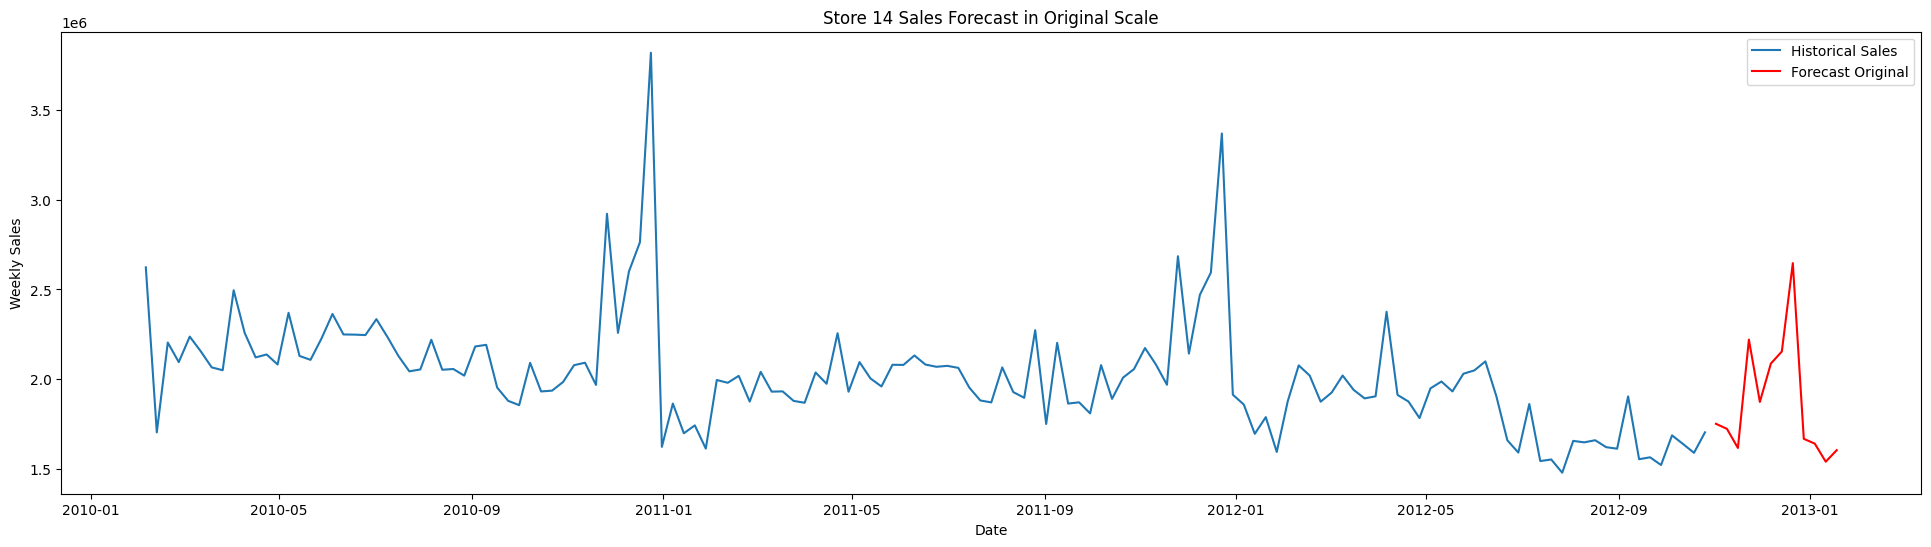

In [70]:
plot_forecast_into_original_scale(store, forecast_original_scale)

In [71]:
forecast_original_scale

,Forecast,Store
2012-11-02,1.751954e+06,14
2012-11-09,1.723929e+06,14
2012-11-16,1.617269e+06,14
2012-11-23,2.220763e+06,14
2012-11-30,1.873749e+06,14
2012-12-07,2.087277e+06,14
2012-12-14,2.154788e+06,14
2012-12-21,2.646840e+06,14
2012-12-28,1.668337e+06,14
2013-01-04,1.641614e+06,14
